In [1]:
import numpy as np
import pandas as pd
import math
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 8})

In [2]:
from sklearn.datasets import load_digits

def digitize_catg_feature(col_index, df):
    ladels = pd.factorize(df.iloc[:, col_index].unique(), na_sentinel=None)
    ladels_replacement = {}
    for i in range(len(ladels[0])): ladels_replacement[ladels[1][i]] = ladels[0][i]
    df.iloc[:, col_index] = df.iloc[:, col_index].replace(ladels_replacement)
    return df

# Wdbc
# data = pd.read_csv(f'datasets/DS01.data', header=None)
# data = data.replace('?', np.nan)
# data = digitize_catg_feature(1, data)
# data = data.dropna()
# data.insert(len(data.columns)-1, 'LABEL', data.pop(1))
# data.to_csv('datasets/DS01.csv', index=False)

# Lung canser
# data = pd.read_csv(f'datasets/DS02.data', header=None)
# data = data.replace('?', np.nan)
# data = data.dropna()
# data.insert(len(data.columns)-1, 'LABEL', data.pop(0))
# data.to_csv('datasets/DS02.csv', index=False)

# data = pd.read_csv(f'datasets/DS03.data', header=None)
# data = data.replace('?', np.nan)
# data = digitize_catg_feature(-1, data)
# data = data.dropna()
# data.insert(len(data.columns)-1, 'LABEL', data.pop(data.columns[-1]))
# data.to_csv('datasets/DS03.csv', index=False)


# digits = load_digits()
# data = pd.DataFrame(data=pd.DataFrame(data=digits['data']))
# data.insert(len(data.columns), 'LABEL', digits['target'])
# data = data.sample(n=1000)
# data.to_csv('datasets/DS04.csv', index=False)

# data = pd.read_csv(f'datasets/raw/MADELON/madelon_train.data', delimiter=r"\s+", header=None)
# y = pd.read_csv(f'datasets/raw/MADELON/madelon_train.labels', header=None)
# data['LABEL'] = y[0]
# data = data.sample(n=600)
# data.to_csv('datasets/DS05.csv', index=False)

# data = pd.read_csv(f'datasets/DS06.data')
# data.drop(columns=data.columns[-5:], axis=1, inplace=True)
# data.drop(columns=["FLOOR"], inplace=True)
# data.insert(len(data.columns)-1, 'LABEL', data.pop(data.columns[-1]))
# data = data.sample(n=900)
# data.to_csv('datasets/DS06.csv', index=False)

# data = pd.read_csv(f'datasets/X_train.txt', delimiter=r"\s+", header=None)
# y = pd.read_csv(f'datasets/y_train.txt', header=None)
# data['LABEL'] = y[0]
# data = data.sample(n=900)
# data.to_csv('datasets/DS07.csv', index=False)

# data = pd.read_csv(f'datasets/final_X_train.txt', delimiter=",", header=None)
# y = pd.read_csv(f'datasets/final_y_train.txt', header=None)
# data['LABEL'] = y[0]
# data = data.sample(n=900)
# data.to_csv('datasets/DS07-2.csv', index=False)

# HAPT
# data = pd.read_csv(f'datasets/raw/HAPT/X_train.txt', delimiter=r"\s+", header=None)
# y = pd.read_csv(f'datasets/raw/HAPT/y_train.txt', header=None)
# data['LABEL'] = y[0]
# data = data.sample(n=1200)
# data.to_csv('datasets/DS08.csv', index=False)

# isolet5
# data = pd.read_csv(f'datasets/isolet5.data', header=None)
# data.insert(len(data.columns)-1, 'LABEL', data.pop(data.columns[-1]))
# data = data.sample(n=1040)
# data.to_csv('datasets/DS09.csv', index=False)


# fac = pd.read_csv(f'datasets/raw/mfeat/mfeat-fac', delimiter=r"\s+", header=None)
# fou = pd.read_csv(f'datasets/raw/mfeat/mfeat-fou', delimiter=r"\s+", header=None)
# kar = pd.read_csv(f'datasets/raw/mfeat/mfeat-kar', delimiter=r"\s+", header=None)
# mor = pd.read_csv(f'datasets/raw/mfeat/mfeat-mor', delimiter=r"\s+", header=None)
# pix = pd.read_csv(f'datasets/raw/mfeat/mfeat-pix', delimiter=r"\s+", header=None)
# zer = pd.read_csv(f'datasets/raw/mfeat/mfeat-zer', delimiter=r"\s+", header=None)
# data = pd.concat([fac, fou, kar, mor, pix, zer], axis=1)
# data['LABEL']=np.divmod(np.arange(len(data)), 200)[0]
# data = data.sample(n=1000)
# data.to_csv('datasets/DS10.csv', index=False)

In [3]:
class MOBGA_AOS:
    def __init__(self, LP = 5, max_nFE = 500, pop_size = 100, p_c = 0.9):
        self.max_nFE = max_nFE
        self.pop_size = pop_size
        self.operator_pool = ['single-point', 'two-point', 'uniform', 'shuffle', 'reduced-surrogate']
        self.LP = LP
        self.p_c = p_c

        # Q = pool_size
        self.Q = len(self.operator_pool)
        self.OSP = [1/self.Q for _ in range(self.Q)]

    def load_data(self, dataset_name):
        data = pd.read_csv(f'datasets/{dataset_name}').to_numpy()
        self.X = data[:, :-1]
        self.y = data[:, -1]
        self.d = self.X.shape[1]
        self.p_m = 1/self.d
        # self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.4, random_state=0)

    def init_pop(self):
        if(self.d > 250):
            pop = []
            for _ in range(self.pop_size):
                individual = np.zeros(self.d)
                ones_num = np.random.randint(20, 100)
                individual[:ones_num] = 1
                np.random.shuffle(individual)
                pop.append(individual)
            return pop
        else:
            return [np.random.choice([0, 1], size=self.d) for _ in range(self.pop_size)]
    
    def one_point_crossover(self, p1, p2):
        cross_point = np.random.randint(0, self.d)
        c1 = list(p1[:cross_point]) + list(p2[cross_point:])
        c2 = list(p2[:cross_point]) + list(p1[cross_point:])
        return [c1, c2]
    
    def two_point_crossover(self, p1, p2):
        cross_points = np.random.randint(0, self.d, 2)
        cross_points = np.sort(cross_points)
        c1 = list(p1[:cross_points[0]]) + list(p2[cross_points[0]:cross_points[1]]) + list(p1[cross_points[1]:])
        c2 = list(p2[:cross_points[0]]) + list(p1[cross_points[0]:cross_points[1]]) + list(p2[cross_points[1]:])
        return [c1, c2]

    def uniform_crossover(self, p1, p2):
        c1 = np.full(self.d, None).tolist()
        c2 = np.full(self.d, None).tolist()
        for i in range(self.d):
            rand_rate = np.random.uniform(0, 1)
            if(rand_rate >= 0.5):
                c1[i] = p1[i]
                c2[i] = p2[i]
            else:
                c1[i] = p2[i]
                c2[i] = p1[i]
        return [c1, c2]
    
    def shuffle_crossover(self, p1, p2):
        c1, c2 = p1, p2
        index = np.random.choice(np.arange(0, self.d), self.d, replace = False)
        ran = np.random.randint(0, self.d)
        for i in range(ran):
            ind = index[i]
            c1[ind] = p2[ind]
            c2[ind] = p1[ind]
        return [c1, c2]
    
    # def shuffle_crossover(self, p1, p2):
    #     p1 = shuffle(p1)
    #     p2 = shuffle(p2)
    #     offsrping = self.one_point_crossover(p1, p2)
    #     return offsrping

    def reduced_surrogate_crossover(self, p1, p2):
        if(len(np.array(np.where(np.array(p1) != np.array(p2))).flatten()) > 0):
            cross_point = np.random.choice(np.array(np.where(np.array(p1) != np.array(p2))).flatten())
            c1 = list(p1[:cross_point]) + list(p2[cross_point:])
            c2 = list(p2[:cross_point]) + list(p1[cross_point:])
            return [c1, c2]
        else:
            return [p1, p2]
    
    def crossover(self, parents, operator_idx):
        p = np.random.uniform(0, 1)
        if p > self.p_c:
            return parents
        
        op_name = self.operator_pool[operator_idx]
        if(op_name == "single-point"):
            offspring = self.one_point_crossover(parents[0], parents[1])
        elif(op_name == "two-point"):
            offspring = self.two_point_crossover(parents[0], parents[1])
        elif(op_name == "uniform"):
            offspring = self.uniform_crossover(parents[0], parents[1])
        elif(op_name == "shuffle"):
            offspring = self.shuffle_crossover(parents[0], parents[1])
        elif(op_name == "reduced-surrogate"):
            offspring = self.reduced_surrogate_crossover(parents[0], parents[1])
        else:
            raise Exception("Unknown crossover operator!")
        
        for i, child in enumerate(offspring):
            if(not np.any(child)): 
                print(op_name)
                print("XOVER")
                print(f"C: {offspring[i]}")
                offspring[i] = parents[i]
                print(f"P: {parents[i]}")
        
        return offspring
    
    def mutation(self, individual):
        # Select a fraction of individual
        frac_idxs = np.random.choice(range(self.d), int(0.5 * self.d))
        indiv = individual.copy()
        for idx in frac_idxs:
            p = np.random.uniform(0, 1)
            if p < self.p_m:
                new_gene = np.random.randint(0, 2)
                # indiv[idx] = new_gene
                indiv[idx] = 0 if (indiv[idx] == 1) else 1
        if(not np.any(indiv)): 
            print("MUTE")
            print(f"C: {individual}")
            print(f"P: {indiv}")
            idx = np.random.randint(0, self.d)
            individual[idx] = 1
            return individual
        else:
            return indiv

    def score_individual_1(self, individual):
        model = KNeighborsClassifier(n_neighbors=3)
        indexes = np.array(np.where(np.array(individual) == 1)).flatten()
        X = (self.X[:, indexes]).reshape(len(self.X), len(indexes))
        ss = ShuffleSplit(n_splits=3, test_size=0.3, random_state=10)
        Nerr_Nall = []
        for train_index, test_index in ss.split(X):
            model.fit(X[train_index], self.y[train_index])
            y_pred = model.predict(X[test_index])
            y_test = self.y[test_index]
            # misclassified = np.where(y_test != y_pred)
            Nerr_Nall.append((np.sum(y_pred != y_test))/len(y_test))
        return np.round(np.mean(Nerr_Nall) * 100, 2)

    def score_individual_2(self, individual):
        return np.sum(individual)
        
    def update_OSP(self, RD, PN):
        S_q_1 = RD.sum(axis=0)
        S_q_2 = PN.sum(axis=0)

        S_q_3 = S_q_2
        S_q_3[S_q_3 == 0] = 0.0001

        S_q_4 = S_q_1/(S_q_2 + S_q_3)
        self.OSP = S_q_4/np.sum(S_q_4)
        if(np.isnan(self.OSP).all()): 
            print("OSP FUCKED")
            self.OSP = [1/self.Q for _ in range(self.Q)]

    def dominance_comparison(self, individuals):
        objective1_values = [self.score_individual_1(individual) for individual in individuals]
        objective2_values = [self.score_individual_2(individual) for individual in individuals]
        and_cond = ((objective1_values[0] <= objective1_values[1]) and (objective2_values[0] <= objective2_values[1]))
        or_cond = ((objective1_values[0] < objective1_values[1]) or (objective2_values[0] < objective2_values[1]))
        return (and_cond and or_cond)

    def credit_assigment(self, parents, offspring, op_idx):
        p1_vs_p2 = self.dominance_comparison(parents)
        p2_vs_p1 = self.dominance_comparison([parents[1], parents[0]])

        if(p1_vs_p2 or p2_vs_p1):
            if(p1_vs_p2): 
                non_dominated_parent = parents[0]
            else: 
                non_dominated_parent = parents[1]
            for i in range(2):
                individuals = [offspring[i], non_dominated_parent]
                ri_vs_p1 = self.dominance_comparison(individuals)
                if(ri_vs_p1):
                    self.n_penalty[op_idx] += 1
                else:
                    self.n_reward[op_idx] += 1
        else:
            for i in range(2):
                individuals = [offspring[i], parents[0]]
                ri_vs_p1 = self.dominance_comparison(individuals)
                individuals = [offspring[i], parents[1]]
                ri_vs_p2 = self.dominance_comparison(individuals)
                if((not ri_vs_p1) and (not ri_vs_p2)):
                    self.n_reward[op_idx] += 1
                else:
                    self.n_penalty[op_idx] += 1

    def plot_pareto_front(self):
        pop = self.population
        fitness_values = self.evaluation(pop)
        index = np.arange(pop.shape[0]).astype(int)
        pareto_front_index = self.pareto_front_finding(fitness_values, index)
        pop = pop[pareto_front_index, :]
        fitness_values = fitness_values[pareto_front_index]
        plt.scatter(fitness_values[:, 1], (fitness_values[:, 0]/100), label='Pareto optimal front', c='red', marker="*", s=25)
        plt.xlabel('Solution size', fontsize=9)
        plt.ylabel('Classification error', fontsize=9)
        plt.show()

    def evaluation(self, pop):
        # 2 values for each choromosome/solution
        fitness_values = np.zeros((pop.shape[0], 2))
        for i, x in enumerate(pop):
            fitness_values[i, 0] = self.score_individual_1(x)
            fitness_values[i, 1] = self.score_individual_2(x)

        return fitness_values   # arr(pop_size x 2)

    def crowding_calculation(self, fitness_values):
        pop_size = len(fitness_values[:, 0])
        # == n of objective functions
        fitness_value_number = len(fitness_values[0, :])
        matrix_for_crowding = np.zeros(
            (pop_size, fitness_value_number))    # arr(pop_size x 2)
        normalized_fitness_values = (
            fitness_values - fitness_values.min(0))/fitness_values.ptp(0)

        for i in range(fitness_value_number):
            crowding_results = np.zeros(pop_size)
            crowding_results[0] = 1  # extreme point has the max crowding distance
            # extreme point has the max crowding distance
            crowding_results[pop_size - 1] = 1
            sorted_normalized_fitness_values = np.sort(
                normalized_fitness_values[:, i])
            sorted_normalized_values_index = np.argsort(
                normalized_fitness_values[:, i])
            # crowding distance calculation. Say for fitness1[i], crowding = fitness1[i+1] - fitness1[i-1]
            crowding_results[1:pop_size - 1] = (sorted_normalized_fitness_values[2:pop_size] -
                                                sorted_normalized_fitness_values[0:pop_size - 2])
            re_sorting = np.argsort(sorted_normalized_values_index)
            matrix_for_crowding[:, i] = crowding_results[re_sorting]

        # on fitness1 - fitness2 plot, each point on pareto front has crowding distance number
        crowding_distance = np.sum(matrix_for_crowding, axis=1)

        return crowding_distance    # arr(pop_size,)

    def pareto_front_finding(self, fitness_values, pop_index):
        pop_size = fitness_values.shape[0]
        pareto_front = np.ones(pop_size, dtype=bool)    # all True initially
        for i in range(pop_size):
            for j in range(pop_size):
                if all(fitness_values[j] <= fitness_values[i]) and any(fitness_values[j] < fitness_values[i]):
                    pareto_front[i] = 0 # i is not in pareto front becouse j dominates i
                    break

        return pop_index[pareto_front]  # arr(len_pareto_front,)

    def remove_using_crowding(self, fitness_values, number_solutions_needed):
        pop_index = np.arange(fitness_values.shape[0])
        crowding_distance = self.crowding_calculation(fitness_values)
        selected_pop_index = np.zeros(number_solutions_needed)
        selected_fitness_values = np.zeros((number_solutions_needed, len(fitness_values[0, :])))    # arr(num_sol_needed x 2)
        for i in range(number_solutions_needed):
            pop_size = pop_index.shape[0]
            solution_1 = random.randint(0, pop_size - 1)
            solution_2 = random.randint(0, pop_size - 1)
            if crowding_distance[solution_1] >= crowding_distance[solution_2]:
                # solution 1 is better than solution 2
                selected_pop_index[i] = pop_index[solution_1]
                selected_fitness_values[i, :] = fitness_values[solution_1, :]
                pop_index = np.delete(pop_index, (solution_1), axis=0)
                fitness_values = np.delete(fitness_values, (solution_1), axis=0)
                crowding_distance = np.delete(
                    crowding_distance, (solution_1), axis=0)
            else:
                # solution 2 is better than solution 1
                selected_pop_index[i] = pop_index[solution_2]
                selected_fitness_values[i, :] = fitness_values[solution_2, :]
                pop_index = np.delete(pop_index, (solution_2), axis=0)
                fitness_values = np.delete(fitness_values, (solution_2), axis=0)
                crowding_distance = np.delete(
                    crowding_distance, (solution_2), axis=0)

        selected_pop_index = np.asarray(selected_pop_index, dtype=int)

        return selected_pop_index   # arr(n_sol_needed,)

    def enviromental_selection(self, pop, fitness_values):
        pop_index_0 = np.arange(pop.shape[0])   # unselected pop ids
        pop_index = np.arange(pop.shape[0])     # all pop ids. len = len(pop_size)
        pareto_front_index = []

        while len(pareto_front_index) < self.pop_size:   # pop_size = initial_pop_size
            new_pareto_front = self.pareto_front_finding(fitness_values[pop_index_0, :], pop_index_0)
            total_pareto_size = len(pareto_front_index) + len(new_pareto_front)

            # check the size of pareto_front, if larger than pop_size then remove some
            if total_pareto_size > self.pop_size:
                number_solutions_needed = self.pop_size - len(pareto_front_index)
                selected_solutions = self.remove_using_crowding(fitness_values[new_pareto_front], number_solutions_needed)
                new_pareto_front = new_pareto_front[selected_solutions]
            
            pareto_front_index = np.hstack((pareto_front_index, new_pareto_front))
            remaining_index = set(pop_index) - set(pareto_front_index)
            pop_index_0 = np.array(list(remaining_index))
            
        selected_pop = pop[pareto_front_index.astype(int)]

        return selected_pop     # arr(pop_size x n_var)

    def fit(self):
        # self.population = self.init_pop()
        RD = np.zeros((self.Q, self.LP))
        PN = np.zeros((self.Q, self.LP))
        self.n_reward = np.zeros(self.Q, dtype=int)
        self.n_penalty = np.zeros(self.Q, dtype=int)
        
        pops = []
        fitness_values_total = []
        # pops = np.array([]).reshape(0, self.d)
        for r_count in range(1):
            print(f"Run ({r_count})")
            self.population = self.init_pop()
            self.OSP = [1/self.Q for _ in range(self.Q)]
            self.generation_count = 0
            self.nFE = 0
            k = 0
            while self.nFE < self.max_nFE:
                pop = np.array(self.population)
                fitness_values = self.evaluation(pop)
                index = np.arange(pop.shape[0]).astype(int)
                pareto_front_index = self.pareto_front_finding(fitness_values, index)
                # pop = pop[pareto_front_index, :]
                # fitness_values = fitness_values[pareto_front_index]
                if(self.generation_count %10 == 0 ):
                    print('Best Individuals in Front-1 for Generation:', self.generation_count)
                    for idx in pareto_front_index:
                        print(pop[idx], end='')
                        print(f", O1: {fitness_values[idx, 0]} ", end='')
                        print(f"| O2: {fitness_values[idx, 1]}")
                    print("\n")
                new_population = np.array(self.population[:])

                for i in range(int(self.pop_size/2)):
                    # Selecting operator using roulette wheel selection
                    operator_idx = np.random.choice(range(0, self.Q), p=self.OSP)
                    # Randomly select two individuals as parents
                    parents_idx = np.random.choice(range(0, self.pop_size), 2)
                    parents = [self.population[idx] for idx in parents_idx]
                    # Crossover
                    offspirng = self.crossover(parents, operator_idx)
                    # Mutation
                    mutated_offspring = [self.mutation(individual) for individual in offspirng]
                    self.credit_assigment(parents, offspirng, operator_idx)
                    
                    # np.append(new_population, mutated_offspring)
                    new_population = np.concatenate((new_population, mutated_offspring))
                    # new_population += mutated_offspring
                    self.nFE += 2
                    
                RD[k, :] = self.n_reward
                PN[k, :] = self.n_penalty
                self.n_reward = np.zeros(self.Q, dtype=int)
                self.n_penalty = np.zeros(self.Q, dtype=int)
                k += 1
                if(k == self.LP):
                    self.update_OSP(RD, PN)
                    k = 0 

                fitness_values = self.evaluation(np.array(new_population))
                self.population = self.enviromental_selection(np.array(new_population), fitness_values)
                
                self.generation_count += 1
            
        #     pop = self.population
        #     fitness_values = self.evaluation(pop)
        #     index = np.arange(pop.shape[0]).astype(int)
        #     pareto_front_index = self.pareto_front_finding(fitness_values, index)
        #     pop = pop[pareto_front_index, :]
        #     pops.append(np.unique(pop, axis=0).tolist()[0])
        #     fitness_values = fitness_values[pareto_front_index]
        #     fitness_values_total.append(np.unique(fitness_values, axis=0).tolist()[0])
        # dominant_fittness = []
        # dominant_pops = []
        # for i in range(len(fitness_values_total)):
        #     for j in range(len(fitness_values_total)):
        #         value1 = fitness_values_total[i]
        #         value2 = fitness_values_total[j]
        #         pop1 = pops[i]
        #         pop2 = pops[j]
        #         if value1 != value2:
        #             if value1[0] < value2[0] and value1[1] < value2[1]:
        #                 if value2 not in dominant_fittness:
        #                     dominant_fittness.append(value2)
        #                     dominant_pops.append(pop2)

        # for value in dominant_fittness:
        #     fitness_values_total.remove(value)
        # for pop in dominant_pops:
        #     pops.remove(pop)

        # self.plot_pareto_front(fitness_values_total)


In [4]:
mobga_ds2 = MOBGA_AOS(max_nFE = 5000)
mobga_ds2.load_data('DS02.csv')
mobga_ds2.fit()

Run (0)
Best Individuals in Front-1 for Generation: 0
[1 1 1 1 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1
 0 1 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 1 0], O1: 22.22 | O2: 30.0
[0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 1 0 0
 0 1 1 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1], O1: 44.44 | O2: 21.0
[0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1], O1: 37.04 | O2: 23.0
[0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1
 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1], O1: 33.33 | O2: 28.0
[1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0], O1: 74.07 | O2: 18.0


Best Individuals in Front-1 for Generation: 10
[0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0], O1: 18.52 | O2: 19.0
[0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0


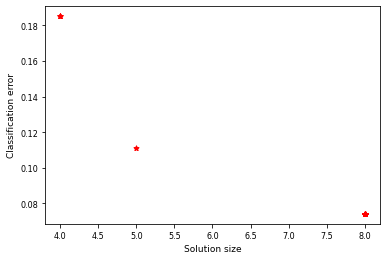

In [5]:
mobga_ds2.plot_pareto_front()

In [6]:
mobga_ds3 = MOBGA_AOS(max_nFE = 4000)
mobga_ds3.load_data('DS03.csv')
mobga_ds3.fit()

Run (0)
Best Individuals in Front-1 for Generation: 0
[1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1
 0 0 1 0 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0], O1: 18.52 | O2: 25.0
[0 1 0 1 1 0 1 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1
 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 0], O1: 17.46 | O2: 27.0
[0 1 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 1 1 1
 1 0 0 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0], O1: 13.23 | O2: 29.0
[0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0
 0 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 0 1], O1: 20.63 | O2: 23.0


Best Individuals in Front-1 for Generation: 10
[0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 0 1], O1: 7.94 | O2: 31.0
[0 1 1 0 0 1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 1
 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 1], O1: 9.52 | O2: 28.0
[0 0 0 0 1 0 0 1 1 1 0 1 1 1 

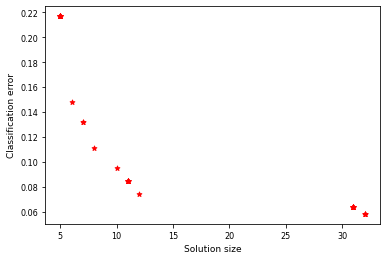

In [7]:
mobga_ds3.plot_pareto_front()

In [8]:
mobga_ds4 = MOBGA_AOS(max_nFE = 4000)
mobga_ds4.load_data('DS04.csv')
mobga_ds4.fit()

Run (0)
Best Individuals in Front-1 for Generation: 0
[0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 0
 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0], O1: 12.11 | O2: 22.0
[1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1
 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0], O1: 8.22 | O2: 23.0
[0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0
 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1], O1: 5.89 | O2: 27.0
[1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0
 1 0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0], O1: 6.11 | O2: 24.0
[1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0
 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0], O1: 2.33 | O2: 28.0
[0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1
 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0], O1: 6.0 | O2: 26.0


Best Individuals in Front-1 for 

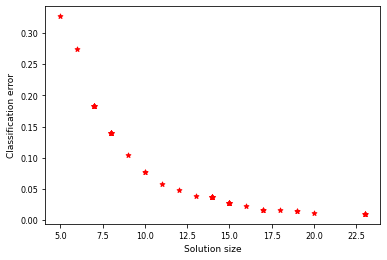

In [9]:
mobga_ds4.plot_pareto_front()

In [10]:
mobga_ds5 = MOBGA_AOS(max_nFE = 4500)
mobga_ds5.load_data('DS05.csv')
mobga_ds5.fit()


Run (0)
Best Individuals in Front-1 for Generation: 0
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

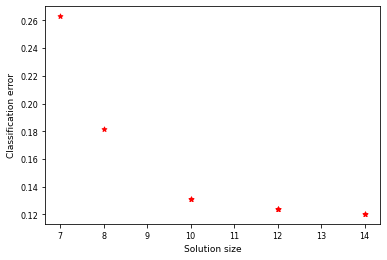

In [11]:
mobga_ds5.plot_pareto_front()

In [12]:
mobga_ds7 = MOBGA_AOS(max_nFE = 5000)
mobga_ds7.load_data('DS07.csv')
mobga_ds7.fit()

Run (0)
Best Individuals in Front-1 for Generation: 0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

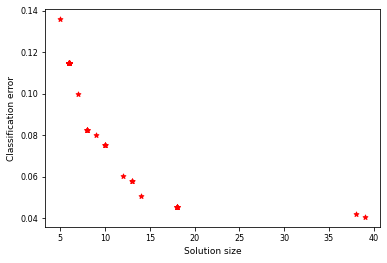

In [13]:
mobga_ds7.plot_pareto_front()

In [14]:
mobga_ds8 = MOBGA_AOS(max_nFE = 5000)
mobga_ds8.load_data('DS08.csv')
mobga_ds8.fit()

Run (0)
Best Individuals in Front-1 for Generation: 0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

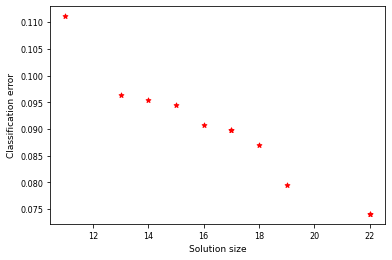

In [15]:
mobga_ds8.plot_pareto_front()

In [16]:
mobga_ds9 = MOBGA_AOS(max_nFE = 5000)
mobga_ds9.load_data('DS09.csv')
mobga_ds9.fit()

Run (0)
Best Individuals in Front-1 for Generation: 0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

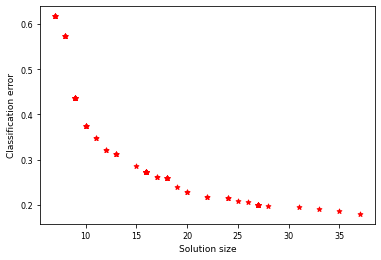

In [17]:
mobga_ds9.plot_pareto_front()

In [18]:
mobga_ds10 = MOBGA_AOS(max_nFE = 4500)
mobga_ds10.load_data('DS10.csv')
mobga_ds10.fit()


Run (0)
Best Individuals in Front-1 for Generation: 0
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

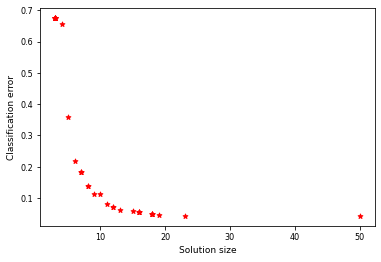

In [19]:
mobga_ds10.plot_pareto_front()